2025-09-22 11:46:00,763 db.db INFO Creating database engine



Summary Statistics:
Date range: 1962-01-01 to 2032-01-01
Date range span: 25567 days (839.9 months, 70.0 years)
Total unique documents with date mentions: 126
Time periods with documents: 43 / 71 years (60.6%)
Average documents per year: 4.46
Maximum documents in a single year: 57


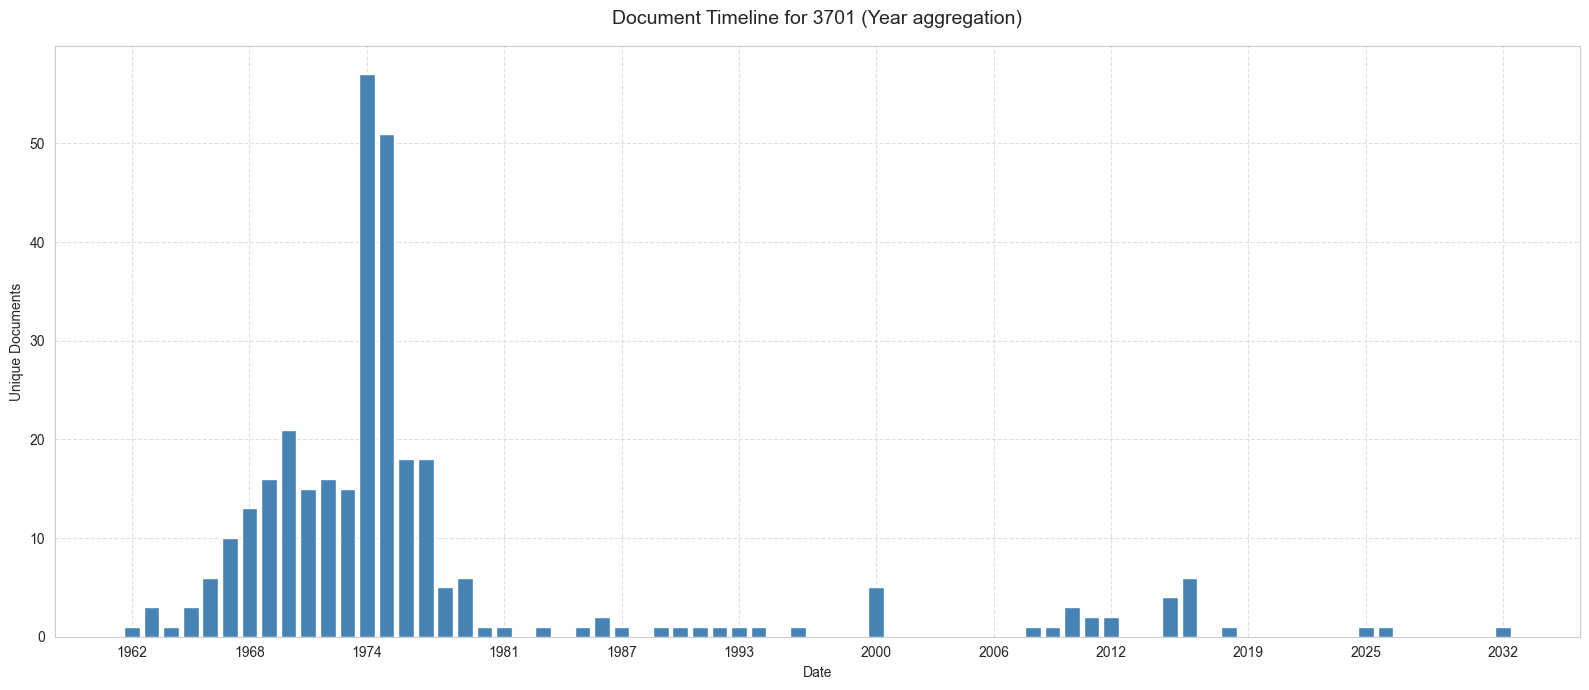

In [12]:
"""
Timeline viz for unique-document date mentions, with correct interval binning
and smart x‑axis tick density/labeling.

Key guarantees:
- Each file is counted at most once per interval (day/week/month/year).
- Weekly bins are anchored to Monday starts; labels show the mid‑week date.
- Ticks are thinned to `max_ticks` while preserving the full aggregation.
- Label formats adapt by interval and rotate 45° (except years).
"""
from __future__ import annotations
import math
from pathlib import Path
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sqlalchemy.orm import sessionmaker
from db.db import get_db_engine
from db.models import FileLocation, FileDateMention, File
from utils import extract_server_dirs

# --- Styling ---------------------------------------------------------------
sns.set_style("whitegrid")
plt.rcParams["figure.facecolor"] = "white"

# --- Helpers ---------------------------------------------------------------
FREQ_MAP = {
    "day": ("D", "%Y-%m-%d"),
    "week": ("W-MON", "%b %d, %Y"),  # bins anchor to Monday
    "month": ("MS", "%b %Y"),        # month starts
    "year": ("YS", "%Y"),            # year starts (Jan 1)
}


def _interval_start_series(dates: pd.Series, interval: str) -> pd.Series:
    """
    Return a datetime64[ns] series of interval starts for each date.
    Weeks are Monday‑anchored to match FREQ_MAP.
    """
    d = pd.to_datetime(dates, errors="coerce")
    if interval == "day":
        return d.dt.floor("D")
    elif interval == "week":
        return d.dt.to_period("W-MON").dt.start_time
    elif interval == "month":
        return d.dt.to_period("M").dt.start_time
    elif interval == "year":
        return d.dt.to_period("Y").dt.start_time
    else:
        raise ValueError(f"Invalid interval: {interval}")


def get_date_data_from_db(
    directory_path: str,
    base_mount: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
) -> pd.DataFrame:
    """
    Query date mentions joined to files limited to a directory tree.
    Returns a DataFrame with file and date mention info.
    """
    try:
        server_dir_prefix = extract_server_dirs(directory_path, base_mount)
    except ValueError as e:
        print(f"Error: {e}")
        return pd.DataFrame()

    try:
        with sessionmaker(bind=get_db_engine())() as session:
            q = (
                session.query(
                    FileLocation.id.label("file_location_id"),
                    FileLocation.filename,
                    File.hash.label("file_hash"),
                    FileDateMention.mention_date,
                    FileDateMention.granularity,
                    FileDateMention.mentions_count,
                )
                .join(File, FileLocation.file_id == File.id)
                .join(FileDateMention, File.hash == FileDateMention.file_hash)
                .filter(FileLocation.file_server_directories.like(f"{server_dir_prefix}%"))
            )
            if start_date:
                q = q.filter(FileDateMention.mention_date >= pd.to_datetime(start_date))
            if end_date:
                q = q.filter(FileDateMention.mention_date <= pd.to_datetime(end_date))

            rows = q.all()
            if not rows:
                print(
                    f"No date mentions found for files in directory: {directory_path}\n"
                    f"Server directory pattern searched: {server_dir_prefix}"
                )
                return pd.DataFrame()

            df = pd.DataFrame(
                rows,
                columns=[
                    "file_location_id",
                    "filename",
                    "file_hash",
                    "mention_date",
                    "granularity",
                    "mentions_count",
                ],
            )
            df["mention_date"] = pd.to_datetime(df["mention_date"], errors="coerce")
            df = df.dropna(subset=["mention_date"]).copy()
            return df
    except Exception as e:
        print(f"Error occurred while querying database: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()


# --- Aggregation logic (correct per-interval unique-file counting) ---------

def aggregate_by_interval(df: pd.DataFrame, interval: str) -> pd.DataFrame:
    """
    Aggregate to unique file count per interval start.
    Ensures each file_hash contributes at most 1 to a given interval.
    """
    if df.empty:
        return pd.DataFrame(columns=["interval_start", "document_count"]) 

    # Compute interval starts and drop duplicates by (file, interval)
    s = _interval_start_series(df["mention_date"], interval)
    work = df.assign(interval_start=s)[["file_hash", "interval_start"]].drop_duplicates()

    # Count unique files per interval (size after dedup is already unique by file)
    agg = (
        work.groupby("interval_start", as_index=False)
        .size()
        .rename(columns={"size": "document_count"})
        .sort_values("interval_start")
    )
    return agg


# --- Fill the complete timeline -------------------------------------------

def create_complete_timeline(
    aggregated_df: pd.DataFrame,
    interval: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
) -> pd.DataFrame:
    """
    Fill in missing intervals in the timeline with zero counts.
    Returns a DataFrame with all intervals between min and max date.
    """
    if aggregated_df.empty:
        return pd.DataFrame(columns=["date", "document_count"]) 

    freq, _fmt = FREQ_MAP[interval]
    min_date = pd.to_datetime(start_date) if start_date else aggregated_df["interval_start"].min()
    max_date = pd.to_datetime(end_date) if end_date else aggregated_df["interval_start"].max()

    # Ensure inclusive range covers the last bin
    rng = pd.date_range(start=min_date, end=max_date, freq=freq)
    full = pd.DataFrame({"date": rng})

    out = (
        full.merge(
            aggregated_df.rename(columns={"interval_start": "date"}),
            on="date",
            how="left",
        )
        .fillna({"document_count": 0})
        .astype({"document_count": int})
    )
    return out


# --- Tick calculation and formatting ---------------------------------------

def prepare_tick_positions(dates: pd.Series, max_ticks: int = 12) -> List[pd.Timestamp]:
    """
    Calculate evenly spaced tick positions for the x-axis.
    Returns a list of pd.Timestamp objects for ticks.
    """
    if dates.empty:
        return []
    n = len(dates)
    if n <= max_ticks:
        return dates.tolist()
    # Evenly spaced indices, always include first/last
    idx = np.linspace(0, n - 1, num=max_ticks, dtype=int)
    idx[0] = 0
    idx[-1] = n - 1
    return [dates.iat[i] for i in idx]


def apply_axis_format(ax, interval: str, max_ticks: int):
    """
    Set x-axis tick formatting and label rotation based on interval.
    """
    # Formatter per interval; weeks show mid‑week label (start + 3d)
    if interval == "year":
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        rot, ha = 0, "center"
    elif interval == "month":
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
        rot, ha = 45, "right"
    elif interval == "week":
        def _fmt_week(x, pos):
            try:
                dt = mdates.num2date(x)  # naive datetime from matplotlib float
                mid = dt + pd.Timedelta(days=3)
                return mid.strftime("%b %d, %Y")
            except Exception:
                return ""
        ax.xaxis.set_major_formatter(FuncFormatter(_fmt_week))
        rot, ha = 45, "right"
    else:  # day
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        rot, ha = 45, "right"

    plt.setp(ax.get_xticklabels(), rotation=rot, ha=ha)


# --- Plotting ---------------------------------------------------------------

def create_timeline_plot(
    timeline_df: pd.DataFrame,
    directory_path: str,
    interval: str,
    max_ticks: int = 12,
    type_str: str = 'line',  # 'line' or 'bar'
) -> plt.Figure:
    """
    Create a timeline plot (line or bar) of unique document counts per interval.
    Returns a matplotlib Figure.
    """
    if timeline_df.empty:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.text(
            0.5,
            0.55,
            f"No date mentions found in\n{directory_path}",
            ha="center",
            va="center",
            fontsize=14,
        )
        ax.set_axis_off()
        fig.suptitle("Document Date Timeline", fontsize=14)
        return fig

    # Figure sizing: wider with more bins
    n_bins = len(timeline_df)
    fig_w = 12 if n_bins <= 60 else 16 if n_bins <= 150 else 20
    fig, ax = plt.subplots(figsize=(fig_w, 7))

    if type_str == 'bar':
        # compute a reasonable bar width in days
        dates = timeline_df['date']
        if len(dates) > 1:
            delta_days = (dates.iloc[1] - dates.iloc[0]).days
        else:
            delta_days = 1
        width = delta_days * 0.8

        # draw bars directly
        ax.bar(
            dates,
            timeline_df['document_count'],
            width=width,
            color='steelblue',
            align='center',
        )
    else:
        sns.lineplot(
            data=timeline_df,
            x="date",
            y="document_count",
            marker="o",
            linewidth=1.6,
            markersize=4,
            ax=ax,
        )

    # Title/labels
    location_name = Path(directory_path).name
    ax.set_title(
        f"Document Timeline for {location_name} ({interval.capitalize()} aggregation)",
        fontsize=14,
        pad=16,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Unique Documents")

    # Ticks
    ticks = prepare_tick_positions(timeline_df["date"], max_ticks=max_ticks)
    if ticks:
        ax.set_xticks(ticks)
    apply_axis_format(ax, interval, max_ticks)

    # Light grid
    ax.grid(True, linestyle="--", alpha=0.6)

    if type_str == 'line':
        ax.fill_between(
            timeline_df["date"],
            0,
            timeline_df["document_count"],
            alpha=0.18,
            step=None,
        )

    fig.tight_layout()
    return fig


# --- Stats -----------------------------------------------------------------

def print_timeline_stats(timeline_df: pd.DataFrame, interval: str, original_df: pd.DataFrame):
    """
    Print summary statistics for the timeline visualization.
    """
    if timeline_df.empty:
        return
    min_date = timeline_df["date"].min()
    max_date = timeline_df["date"].max()
    span_days = (max_date - min_date).days
    total_unique_files = original_df["file_hash"].nunique()
    periods_with_docs = int((timeline_df["document_count"] > 0).sum())
    print("\nSummary Statistics:")
    print(f"Date range: {min_date:%Y-%m-%d} to {max_date:%Y-%m-%d}")
    print(
        f"Date range span: {span_days} days ({span_days/30.44:.1f} months, {span_days/365.25:.1f} years)"
    )
    print(f"Total unique documents with date mentions: {total_unique_files}")
    print(
        f"Time periods with documents: {periods_with_docs} / {len(timeline_df)} {interval}s "
        f"({periods_with_docs/len(timeline_df)*100:.1f}%)"
    )
    print(f"Average documents per {interval}: {timeline_df['document_count'].mean():.2f}")
    print(f"Maximum documents in a single {interval}: {timeline_df['document_count'].max()}")


# --- Orchestrator ----------------------------------------------------------

def document_date_timeline_viz(
    directory_path: str,
    base_mount: str,
    agg_interval: str = "day", # "day", "week", "month", or "year" 
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    max_xtick_labels: int = 12,
    type_str = 'line'
) -> Tuple[pd.DataFrame, plt.Figure]:
    """
    Orchestrate the timeline visualization: query, aggregate, plot, and print stats.
    Returns the timeline DataFrame and matplotlib Figure.
    """
    # Validate interval
    if agg_interval not in FREQ_MAP:
        print(f"Warning: Invalid interval '{agg_interval}'. Using 'day' instead.")
        agg_interval = "day"

    # Data
    df = get_date_data_from_db(directory_path, base_mount, start_date, end_date)
    if df.empty:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.text(
            0.5,
            0.55,
            f"No date mentions found in\n{directory_path}",
            ha="center",
            va="center",
            fontsize=14,
        )
        ax.set_axis_off()
        fig.suptitle("Document Date Timeline", fontsize=14)
        return pd.DataFrame(columns=["date", "document_count"]), fig

    # Aggregate → complete timeline → plot
    aggregated = aggregate_by_interval(df, agg_interval)
    timeline_df = create_complete_timeline(aggregated, agg_interval, start_date, end_date)
    fig = create_timeline_plot(timeline_df=timeline_df,
                               directory_path=directory_path,
                               interval=agg_interval,
                               max_ticks =max_xtick_labels,
                               type_str=type_str)

    # Stats
    print_timeline_stats(timeline_df, agg_interval, df)

    return timeline_df, fig


# --- Example (commented) ---------------------------------------------------
base_mount = r"N:\\PPDO\\Records"
directory_to_analyze = r"N:\\PPDO\\Records\\37xx   Oakes College\\3701\\3701"
timeline_df, fig = document_date_timeline_viz(
    directory_to_analyze,
    base_mount,
    agg_interval="year",
    max_xtick_labels=12,
    type_str='bar'
)
plt.show()


In [13]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from typing import Optional, Tuple
from datetime import timedelta
from pathlib import Path
from dataclasses import dataclass, asdict

FREQ_MAP = {
    "day": ("D", "%Y-%m-%d"),
    "week": ("W-MON", "%b %d, %Y"),  # bins anchor to Monday
    "month": ("MS", "%b %Y"),        # month starts
    "year": ("YS", "%Y"),            # year starts (Jan 1)
}

# --- Cleaning parameter container ----------------------------------------------
@dataclass
class CleaningParams:
    """Parameters controlling date mention cleaning steps.

    Attributes
    ----------
    year_min, year_max : int
        Inclusive year bounds; rows outside dropped.
    use_dbscan : bool
        Whether to apply 1-D DBSCAN clustering over dates to remove sparse outliers.
    dbscan_eps_days : int
        Neighborhood size (days) for DBSCAN.
    dbscan_min_samples : int
        Minimum samples in an eps neighborhood for a core point.
    use_year_freq : bool
        Whether to drop weak years based on relative + absolute mention thresholds.
    year_freq_ratio : float
        Relative threshold as a fraction of the max yearly mentions.
    year_freq_min_abs : int
        Absolute minimum mentions for a year to be retained.

    Notes
    -----
    Pass an instance of this class to both single- and multi-project Plotly timeline functions
    via the `cleaning` parameter. If None is supplied, raw (unfiltered) data is used.
    """
    year_min: int = 1960
    year_max: int = 2035
    use_dbscan: bool = True
    dbscan_eps_days: int = 120
    dbscan_min_samples: int = 5
    use_year_freq: bool = True
    year_freq_ratio: float = 0.02
    year_freq_min_abs: int = 5

    def to_report(self) -> dict:
        return asdict(self)


# --- Date Annotation for Timeline Visualizations ---------------------------------
@dataclass
class DateAnnotation:
    """Represents a date annotation for timeline visualizations.
    
    Attributes
    ----------
    date : str
        Date string in format compatible with pd.to_datetime (e.g., '2020-01-01', 'Jan 2020').
    label : str
        Text label for the annotation.
    position : str
        Vertical position: 'above' or 'below' the timeline.
    color : str
        Color for the annotation line and text (CSS color or hex).
    line_dash : str
        Line dash style: 'solid', 'dash', 'dot', 'dashdot'.
    show_line : bool
        Whether to show the vertical line.
    show_label : bool
        Whether to show the text label.
    """
    date: str
    label: str
    position: str = 'above'
    color: str = 'red'
    line_dash: str = 'dash'
    show_line: bool = True
    show_label: bool = True
    
    def __post_init__(self):
        """Validate position and line_dash values."""
        if self.position not in ['above', 'below']:
            raise ValueError(f"position must be 'above' or 'below', got '{self.position}'")
        
        valid_dashes = ['solid', 'dash', 'dot', 'dashdot']
        if self.line_dash not in valid_dashes:
            raise ValueError(f"line_dash must be one of {valid_dashes}, got '{self.line_dash}'")


def _add_date_annotations(
    fig: go.Figure, 
    annotations: List[DateAnnotation], 
    timeline_df: pd.DataFrame, 
    interval: str
) -> None:
    """Add vertical lines and annotations to a plotly timeline figure.
    
    Parameters
    ----------
    fig : go.Figure
        The plotly figure to modify in-place.
    annotations : List[DateAnnotation]
        List of date annotations to add.
    timeline_df : pd.DataFrame
        Timeline data with 'date' and 'document_count' columns.
    interval : str
        Aggregation interval ('day', 'week', 'month', 'year').
    """
    if not annotations or timeline_df.empty:
        return
    
    # Get y-axis range for positioning
    y_data = timeline_df['document_count']
    y_min, y_max = y_data.min(), y_data.max()
    y_range = y_max - y_min if y_max > y_min else 1
    
    # Position offsets for above/below
    above_offset = y_max + 0.15 * y_range
    below_offset = y_min - 0.1 * y_range
    
    for ann in annotations:
        try:
            # Parse annotation date
            ann_date = pd.to_datetime(ann.date)
            
            # Check if date is within timeline range
            timeline_dates = pd.to_datetime(timeline_df['date'])
            if ann_date < timeline_dates.min() or ann_date > timeline_dates.max():
                print(f"Warning: Annotation date {ann.date} is outside timeline range")
                continue
            
            # Add vertical line if requested
            if ann.show_line:
                fig.add_vline(
                    x=ann_date,
                    line_dash=ann.line_dash,
                    line_color=ann.color,
                    line_width=2,
                    opacity=0.8
                )
            
            # Add text annotation if requested
            if ann.show_label:
                y_pos = above_offset if ann.position == 'above' else below_offset
                y_anchor = 'bottom' if ann.position == 'above' else 'top'
                
                fig.add_annotation(
                    x=ann_date,
                    y=y_pos,
                    text=ann.label,
                    showarrow=True,
                    arrowhead=2,
                    arrowsize=1,
                    arrowwidth=2,
                    arrowcolor=ann.color,
                    ax=0,
                    ay=-20 if ann.position == 'above' else 20,
                    font=dict(color=ann.color, size=12),
                    yanchor=y_anchor,
                    bgcolor="rgba(255,255,255,0.8)",
                    bordercolor=ann.color,
                    borderwidth=1
                )
                
        except Exception as e:
            print(f"Warning: Failed to add annotation for date {ann.date}: {e}")
            continue

# --- Cleaning helper functions (each strategy modular) ---------------------------
try:
    from sklearn.cluster import DBSCAN
    _HAVE_SKLEARN = True
except Exception:
    _HAVE_SKLEARN = False

def filter_year_bounds(df: pd.DataFrame, year_min: int, year_max: int) -> tuple[pd.DataFrame, int]:
    """Remove rows whose mention_date year is outside [year_min, year_max]."""
    if df.empty:
        return df, 0
    before = len(df)
    mask = (df.mention_date.dt.year >= year_min) & (df.mention_date.dt.year <= year_max)
    out = df[mask].copy()
    return out, before - len(out)

def filter_dbscan_outliers(df: pd.DataFrame, eps_days: int, min_samples: int) -> tuple[pd.DataFrame, int]:
    """Use 1-D DBSCAN over unique dates (ordinal days) to drop sparse outliers.

    Returns
    -------
    (filtered_df, removed_count)
    """
    if df.empty or not _HAVE_SKLEARN:
        return df.copy(), 0
    unique_dates = df['mention_date'].drop_duplicates().sort_values()
    if len(unique_dates) < max(10, min_samples * 2):
        return df.copy(), 0  # not enough data for clustering
    ordinals = unique_dates.map(pd.Timestamp.toordinal).to_numpy().reshape(-1, 1)
    labels = DBSCAN(eps=eps_days, min_samples=min_samples).fit_predict(ordinals)
    keep_dates = set(unique_dates[labels != -1])
    before = len(df)
    out = df[df.mention_date.isin(keep_dates)].copy()
    return out, before - len(out)

def filter_year_frequency(df: pd.DataFrame, freq_ratio: float, min_abs: int) -> tuple[pd.DataFrame, int]:
    """Remove weak years with very low total mentions relative and absolute thresholds."""
    if df.empty:
        return df, 0
    counts = (
        df.groupby(df.mention_date.dt.year)
          .agg(total_mentions=('mentions_count','sum'))
          .rename_axis('year')
          .reset_index()
    )
    if counts.empty:
        return df, 0
    max_mentions = counts.total_mentions.max() or 1
    weak_years = counts[
        (counts.total_mentions < max_mentions * freq_ratio) &
        (counts.total_mentions < min_abs)
    ]['year'].tolist()
    if not weak_years:
        return df, 0
    before = len(df)
    out = df[~df.mention_date.dt.year.isin(weak_years)].copy()
    return out, before - len(out)

def clean_date_mentions_pipeline(
    df: pd.DataFrame,
    year_min: int = 1960,
    year_max: int = 2035,
    use_dbscan: bool = True,
    dbscan_eps_days: int = 120,
    dbscan_min_samples: int = 5,
    use_year_freq: bool = True,
    year_freq_ratio: float = 0.02,
    year_freq_min_abs: int = 5,
    verbose: bool = True,
    return_report: bool = False,
 ):
    """Apply modular cleaning steps to date mentions DataFrame.

    Expects columns: mention_date (datetime64), mentions_count, file_hash.

    Returns cleaned df (and optionally a dict report)."""
    if df.empty:
        return (df, {}) if return_report else df
    report: dict[str,int|str] = {}
    work = df.copy()
    work, removed_year_window = filter_year_bounds(work, year_min, year_max)
    report['removed_year_window'] = removed_year_window
    removed_dbscan = 0
    if use_dbscan:
        work, removed_dbscan = filter_dbscan_outliers(work, dbscan_eps_days, dbscan_min_samples)
    report['removed_dbscan'] = removed_dbscan
    removed_year_freq = 0
    if use_year_freq:
        work, removed_year_freq = filter_year_frequency(work, year_freq_ratio, year_freq_min_abs)
    report['removed_year_frequency'] = removed_year_freq
    report['final_rows'] = len(work)
    report['initial_rows'] = len(df)
    report['total_removed'] = removed_year_window + removed_dbscan + removed_year_freq
    if verbose:
        print("Date cleaning summary:")
        for k,v in report.items():
            if k.endswith('_rows'):
                continue
            print(f"  {k}: {v}")
    return (work, report) if return_report else work

def apply_cleaning(df: pd.DataFrame, params: CleaningParams | None, verbose: bool, return_report: bool):
    """Convenience wrapper to run cleaning using a CleaningParams object.

    If params is None returns original data (and empty report when requested)."""
    if params is None:
        if return_report:
            return df, {}
        return df
    return clean_date_mentions_pipeline(
        df,
        year_min=params.year_min,
        year_max=params.year_max,
        use_dbscan=params.use_dbscan,
        dbscan_eps_days=params.dbscan_eps_days,
        dbscan_min_samples=params.dbscan_min_samples,
        use_year_freq=params.use_year_freq,
        year_freq_ratio=params.year_freq_ratio,
        year_freq_min_abs=params.year_freq_min_abs,
        verbose=verbose,
        return_report=return_report,
    )

def _format_tick_label(ts: pd.Timestamp, interval: str) -> str:
    if interval == "year":
        return ts.strftime("%Y")
    elif interval == "month":
        return ts.strftime("%b %Y")
    elif interval == "week":
        return (ts + pd.Timedelta(days=3)).strftime("%b %d, %Y")
    else:
        return ts.strftime("%Y-%m-%d")

def create_timeline_plot_plotly(
    timeline_df: pd.DataFrame,
    directory_path: str,
    interval: str,
    max_ticks: int = 12,
    type_str: str = "line",
    annotations: Optional[List[DateAnnotation]] = None,
    ):
    """Plotly timeline of unique document counts per interval.

    Mirrors Matplotlib behavior and supports 'line' (with area fill) and 'bar'."""
    title_loc = Path(directory_path).name if directory_path else "Selection"
    if timeline_df.empty:
        fig = go.Figure()
        fig.add_annotation(
            text=f"No date mentions found in<br>{directory_path}",
            xref="paper", yref="paper", x=0.5, y=0.6, showarrow=False, font=dict(size=16)
        )
        fig.update_layout(
            title="Document Date Timeline",
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            plot_bgcolor="white",
        )
        return fig
    dates = pd.to_datetime(timeline_df["date"])
    counts = timeline_df["document_count"].astype(int)
    if type_str == "bar":
        if len(dates) > 1:
            delta_days = (dates.iloc[1] - dates.iloc[0]).days or 1
        else:
            delta_days = 1
        width_ms = int(delta_days * 0.8 * 24 * 3600 * 1000)
        trace = go.Bar(x=dates, y=counts, width=[width_ms] * len(dates))
    else:
        trace = go.Scatter(
            x=dates,
            y=counts,
            mode="lines+markers",
            line=dict(width=2),
            marker=dict(size=5),
            fill="tozeroy",
        )
    fig = go.Figure(data=[trace])
    tick_positions = prepare_tick_positions(dates, max_ticks=max_ticks)
    tick_text = [_format_tick_label(pd.to_datetime(t), interval) for t in tick_positions]
    angle = 0 if interval == "year" else 45
    fig.update_layout(
        title=f"Document Timeline for {title_loc} ({interval.capitalize()} aggregation)",
        xaxis=dict(
            title="Date",
            tickmode="array",
            tickvals=tick_positions,
            ticktext=tick_text,
            tickangle=angle,
            showgrid=True,
            gridcolor="rgba(0,0,0,0.1)",
            zeroline=False,
        ),
        yaxis=dict(
            title="Unique Documents",
            showgrid=True,
            gridcolor="rgba(0,0,0,0.1)",
            zeroline=False,
        ),
        plot_bgcolor="white",
        margin=dict(l=60, r=20, t=70, b=60),
    )
    
    # Add date annotations if provided
    if annotations:
        _add_date_annotations(fig, annotations, timeline_df, interval)
    
    return fig

def document_date_timeline_viz_plotly(
    directory_path: str,
    base_mount: str,
    agg_interval: str = "day",
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    max_xtick_labels: int = 12,
    type_str: str = "line",
    show_stats: bool = True,
    cleaning: CleaningParams | None = None,
    verbose_clean: bool = True,
    return_clean_report: bool = False,
    annotations: Optional[List[DateAnnotation]] = None,
 ) -> Tuple[pd.DataFrame, go.Figure] | Tuple[pd.DataFrame, go.Figure, dict]:
    """Plotly version with simplified cleaning via CleaningParams.

    If `cleaning` is None, the raw queried data is used without filtering.
    When `return_clean_report` is True returns (timeline_df, fig, report).
    The cleaning report and params are also embedded into `fig.layout.meta`."""
    if agg_interval not in FREQ_MAP:
        print(f"Warning: Invalid interval '{agg_interval}'. Using 'day' instead.")
        agg_interval = "day"
    df = get_date_data_from_db(directory_path, base_mount, start_date, end_date)
    if df.empty:
        empty_fig = create_timeline_plot_plotly(
            pd.DataFrame(columns=["date", "document_count"]),
            directory_path=directory_path,
            interval=agg_interval,
            max_ticks=max_xtick_labels,
            type_str=type_str,
        )
        if return_clean_report:
            empty_fig.update_layout(meta={"clean_report": {}, "cleaning_params": asdict(cleaning) if cleaning else {}})
            return pd.DataFrame(columns=["date", "document_count"]), empty_fig, {}
        return pd.DataFrame(columns=["date", "document_count"]), empty_fig
    cleaned, report = apply_cleaning(df, cleaning, verbose_clean, return_report=True)
    aggregated = aggregate_by_interval(cleaned, agg_interval)
    timeline_df = create_complete_timeline(
        aggregated, agg_interval, start_date=start_date, end_date=end_date
    )
    fig = create_timeline_plot_plotly(
        timeline_df=timeline_df,
        directory_path=directory_path,
        interval=agg_interval,
        max_ticks=max_xtick_labels,
        type_str=type_str,
        annotations=annotations,
    )
    if show_stats:
        print_timeline_stats(timeline_df, agg_interval, cleaned)
    if return_clean_report:
        existing_meta = fig.layout.meta or {}
        if not isinstance(existing_meta, dict):
            existing_meta = {"_original_meta": existing_meta}
        merged_meta = {**existing_meta, "clean_report": report, "cleaning_params": asdict(cleaning) if cleaning else {}}
        fig.update_layout(meta=merged_meta)
        return timeline_df, fig, report
    return timeline_df, fig

# --- Example usage (updated with CleaningParams) ---------------------------------------
base_mount = r"N:\\PPDO\\Records"
directory_to_analyze = r"N:\\PPDO\\Records\\37xx   Oakes College\\3701\\3701"
clean_params = CleaningParams(year_min=1965, year_max=2025, dbscan_eps_days=90, dbscan_min_samples=5, year_freq_min_abs=3)
plotly_timeline_df, plotly_fig, clean_report = document_date_timeline_viz_plotly(
    directory_to_analyze,
    base_mount,
    agg_interval="month",
    max_xtick_labels=12,
    type_str='bar',
    cleaning=clean_params,
    verbose_clean=True,
    return_clean_report=True,
 )
print("Clean report:", clean_report)
plotly_fig.show()

2025-09-22 11:46:01,345 db.db INFO Creating database engine


Date cleaning summary:
  removed_year_window: 8
  removed_dbscan: 63
  removed_year_frequency: 3
  total_removed: 74

Summary Statistics:
Date range: 1967-01-01 to 2015-07-01
Date range span: 17713 days (581.9 months, 48.5 years)
Total unique documents with date mentions: 121
Time periods with documents: 145 / 583 months (24.9%)
Average documents per month: 1.29
Maximum documents in a single month: 25
Clean report: {'removed_year_window': 8, 'removed_dbscan': 63, 'removed_year_frequency': 3, 'final_rows': 1975, 'initial_rows': 2049, 'total_removed': 74}


In [ ]:
# Multi-project Plotly visualization (refactored to use CleaningParams)
from typing import Sequence, Literal

def _infer_bar_width_ms(dates: pd.Series) -> int:
    """Infer bar width (ms) as 80% of the first interval between consecutive dates.

    Falls back to a 1-day width if only one date or irregular spacing. """
    if dates is None or len(dates) == 0:
        return 24 * 3600 * 1000
    if len(dates) > 1:
        delta_days = (dates.iloc[1] - dates.iloc[0]).days or 1
    else:
        delta_days = 1
    return int(delta_days * 0.8 * 24 * 3600 * 1000)

def multi_project_date_timeline_viz_plotly(
    directory_paths: Sequence[str],
    base_mount: str,
    agg_interval: str = "month",
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    max_xtick_labels: int = 18,
    type_str: str = "line",   # 'line' or 'bar'
    cleaning: CleaningParams | None = None,
    verbose_clean: bool = False,
    return_individual: bool = False,
    annotations: Optional[List[DateAnnotation]] = None,
) -> Tuple[pd.DataFrame, go.Figure] | Tuple[pd.DataFrame, go.Figure, pd.DataFrame]:
    """
    Simplified multi-project timeline: aggregates (sums) document counts across all
    provided directories into a single combined timeline.

    For each directory:
      1. Query date mentions.
      2. Apply optional cleaning (CleaningParams).
      3. Aggregate to unique-document counts per interval.
      4. Fill missing intervals.

    Then sums per-interval counts across projects.

    Parameters
    ----------
    directory_paths : Sequence[str]
        Project directory absolute paths.
    base_mount : str
        Base mount used for server path extraction.
    agg_interval : str
        One of day|week|month|year.
    type_str : str
        'line' or 'bar'.
    cleaning : CleaningParams | None
        Cleaning parameters; if None, raw data.
    return_individual : bool
        If True also returns long-form per-project timeline counts.

    Returns
    -------
    combined_timeline : DataFrame
        Columns: ['date','document_count'] (summed across projects).
    fig : go.Figure
        Plotly figure (single combined trace).
    (optional) long_df : DataFrame
        If requested: ['project','date','document_count'] per project.
    """
    if agg_interval not in FREQ_MAP:
        raise ValueError(f"Invalid interval {agg_interval}")
    if not directory_paths:
        empty = pd.DataFrame(columns=['date','document_count'])
        fig = go.Figure()
        fig.add_annotation(text="No directories provided", x=0.5, y=0.5, showarrow=False)
        return (empty, fig, empty) if return_individual else (empty, fig)

    project_results: list[Tuple[str, pd.DataFrame]] = []
    meta_reports: dict[str, dict] = {}

    for path in directory_paths:
        try:
            df = get_date_data_from_db(path, base_mount, start_date, end_date)
            if df.empty:
                continue
            cleaned, report = apply_cleaning(df, cleaning, verbose_clean, return_report=True)
            aggregated = aggregate_by_interval(cleaned, agg_interval)
            timeline = create_complete_timeline(
                aggregated, agg_interval, start_date=start_date, end_date=end_date
            )
            name = Path(path).name
            if not timeline.empty:
                project_results.append((name, timeline))
                meta_reports[name] = {**report, 'cleaning_params': asdict(cleaning) if cleaning else {}}
        except Exception as e:
            print(f"Warning: failed processing {path}: {e}")
            continue

    if not project_results:
        empty = pd.DataFrame(columns=['date','document_count'])
        fig = go.Figure()
        fig.add_annotation(text="No data after filtering", x=0.5, y=0.5, showarrow=False)
        fig.update_layout(title="Multi-Project Document Date Timeline")
        return (empty, fig, empty) if return_individual else (empty, fig)

    # Long form per-project
    long_rows = []
    for name, tl in project_results:
        tmp = tl.copy()
        tmp['project'] = name
        long_rows.append(tmp[['project','date','document_count']])
    long_df = pd.concat(long_rows, ignore_index=True)

    # Sum across projects
    combined = (long_df.groupby('date', as_index=False)
                        .agg(document_count=('document_count','sum'))
                        .sort_values('date'))

    # Build figure (reuse single-project plot creator, then retitle)
    fig = create_timeline_plot_plotly(
        timeline_df=combined,
        directory_path="",  # placeholder
        interval=agg_interval,
        max_ticks=max_xtick_labels,
        type_str=type_str,
        annotations=annotations,
    )
    fig.update_layout(title=f"Multi-Project Timeline (Combined, {agg_interval})")

    # Attach meta (no mode now)
    fig_meta = {
        'projects': list(meta_reports.keys()),
        'reports': meta_reports,
        'interval': agg_interval,
        'cleaning_params': asdict(cleaning) if cleaning else {}
    }
    existing_meta = getattr(fig.layout, 'meta', None) or {}
    if not isinstance(existing_meta, dict):
        existing_meta = {'_original_meta': existing_meta}
    merged_meta = {**existing_meta, 'multi_clean_reports': fig_meta}
    fig.update_layout(meta=merged_meta)

    if return_individual:
        return combined, fig, long_df
    return combined, fig

# Example multi-project usage (adjust paths as needed)
example_projects = [
    r"N:\\PPDO\\Records\\37xx   Oakes College\\3701\\3701",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6300\\6300-014",
    r"N:\\PPDO\\Records\\100xx  Multiple Locations\\10010\\10010",
    r"N:\\PPDO\\Records\\111xx  Area Planning Documents and Studies\\11105",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6300\\6300-002",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6300\\6300-004",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6300\\6300-007",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6300\\6300-011",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6300\\6300-014",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6301\\6301",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6301\\6301-001",
    r"N:\\PPDO\\Records\\90xx  Campus Utilities\\9098\\9098D",
    r"N:\\PPDO\\Records\\100xx  Multiple Locations\\10000\\10000-206",
    r"N:\\PPDO\\Records\\31xx   Performing Arts Center\\3124\\3124-003",
    r"N:\\PPDO\\Records\\63xx   Music Facility\\6302\\6302"
 ]

combined_df, multi_fig = multi_project_date_timeline_viz_plotly(
    example_projects,
    base_mount=base_mount,
    agg_interval='month',
    type_str='bar',
    max_xtick_labels=12,
    cleaning=clean_params,
    return_individual=False,
)
multi_fig.show()

2025-09-22 11:50:36,052 db.db INFO Creating database engine
2025-09-22 11:50:37,893 db.db INFO Creating database engine
2025-09-22 11:50:37,893 db.db INFO Creating database engine
2025-09-22 11:50:38,539 db.db INFO Creating database engine
2025-09-22 11:50:38,539 db.db INFO Creating database engine
2025-09-22 11:50:39,132 db.db INFO Creating database engine
2025-09-22 11:50:39,132 db.db INFO Creating database engine
2025-09-22 11:50:39,563 db.db INFO Creating database engine
2025-09-22 11:50:39,563 db.db INFO Creating database engine
2025-09-22 11:50:39,966 db.db INFO Creating database engine
2025-09-22 11:50:39,966 db.db INFO Creating database engine
2025-09-22 11:50:40,354 db.db INFO Creating database engine
2025-09-22 11:50:40,354 db.db INFO Creating database engine
2025-09-22 11:50:40,727 db.db INFO Creating database engine
2025-09-22 11:50:40,727 db.db INFO Creating database engine
2025-09-22 11:50:41,180 db.db INFO Creating database engine
2025-09-22 11:50:41,180 db.db INFO Creat

No date mentions found for files in directory: N:\\PPDO\\Records\\63xx   Music Facility\\6301\\6301-001
Server directory pattern searched: 63xx   Music Facility/6301/6301-001


2025-09-22 11:50:42,566 db.db INFO Creating database engine


No date mentions found for files in directory: N:\\PPDO\\Records\\90xx  Campus Utilities\\9098\\9098D
Server directory pattern searched: 90xx  Campus Utilities/9098/9098D


2025-09-22 11:50:42,926 db.db INFO Creating database engine
2025-09-22 11:50:43,303 db.db INFO Creating database engine
2025-09-22 11:50:43,303 db.db INFO Creating database engine
2025-09-22 11:50:43,671 db.db INFO Creating database engine
2025-09-22 11:50:43,671 db.db INFO Creating database engine
